# Прогнозирование заказов такси

<a id='task'></a>
## Постановка задачи

**Тема проекта:** разработка модели машинного обучения для предсказания количества заказов такси на следующий час.

### Назначение

**Цели проекта:** построить модель, прогрозирующую количество заказов такси на следующий час. 

Значение метрики RMSE на тестовой выборке должно быть не больше 48.

### Структура проекта
1. [Постановка задачи][1]
    1. Назначение
    2. Структура проекта
    3. Описание данных
2. [Загрузка данных][2]
3. [Исследовательский анализ данных][3]
4. [Обучение моделей][4]
    1. [Подготовка данных][4.1]
    2. [Линейная модель][4.2]
    3. [Модель LightGBM][4.3]
    4. [Модель DecisionTreeRegressor][4.4]
    5. [Сравнение моделей][4.5]
    6. [Качество лучшей модели на тестовой выборке][4.6]
5. [Общие выводы][5]

[1]:#task
[2]:#general
[3]:#research
[4]:#model
[4.1]:#prep
[4.2]:#lin
[4.3]:#lgbm
[4.4]:#tree
[4.5]:#comp
[4.6]:#test
[5]:#fin

### Описание данных

Данные находятся в файле `taxi.csv`.

**Целевой признак:**
- `num_orders` — количество заказов

<a id='general'></a>
## Загрузка данных

Подготовка к работе с данными: загружаем библиотеки.

In [1]:
# импорт библиотек
import numpy as np
import pandas as pd
import os
import sklearn
from sklearn.pipeline import Pipeline
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
import warnings
warnings.filterwarnings("ignore")

# загружаем классы для подготовки данных
from sklearn.preprocessing import (
    OrdinalEncoder,
    OneHotEncoder,
    StandardScaler,
    MinMaxScaler
)
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer

from sklearn.model_selection import (
    train_test_split,
    GridSearchCV,
    TimeSeriesSplit
)

# библиотеки для графиков
import matplotlib.pyplot as plt
import seaborn as sns

# для моделей
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
try:
    import lightgbm
except:
    !pip install lightgbm
    import lightgbm    
    
from lightgbm import LGBMRegressor

In [39]:
from sklearn.dummy import DummyRegressor 

In [2]:
sklearn.__version__

'1.5.0'

In [3]:
RANDOM_STATE = 52
TEST_SIZE = 0.1

In [4]:
# подготовка для графиков
palette = ["#F72585", "#4361EE",
           "#b5179e", "#4CC9F0", 
           "#7209B7", "#3A0CA3"]
sns.set(rc={'figure.figsize':(14,7)},
        palette=palette, 
        font_scale=0.95)
sns.set_style(rc = {'axes.facecolor': '#e9e9f0'})

In [5]:
# расширение границ для работы с тетрадкой
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:90% !important; }</style>"))

Считываем датафрейм.

In [6]:
# функция считывания датафрейма
def read_dfs(path, name):
    for i in path:
        if os.path.exists(i+name):
            return pd.read_csv(i+name, index_col=[0], parse_dates=[0])
    return print('File not found')

In [7]:
# записываем возможные пути
paths = ['/datasets/', 
         'https://code.s3.yandex.net/datasets/', 
         'C:\\Users\\Admin\\YandexDisk\\']
# разделение данных
df_name = 'taxi.csv'
taxi = read_dfs(paths, df_name)

taxi.head(10)

,num_orders
datetime,
2018-03-01 00:00:00,9
2018-03-01 00:10:00,14
2018-03-01 00:20:00,28
2018-03-01 00:30:00,20
2018-03-01 00:40:00,32
2018-03-01 00:50:00,21
2018-03-01 01:00:00,7
2018-03-01 01:10:00,5
2018-03-01 01:20:00,17


In [8]:
taxi.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 26496 entries, 2018-03-01 00:00:00 to 2018-08-31 23:50:00
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype
---  ------      --------------  -----
 0   num_orders  26496 non-null  int64
dtypes: int64(1)
memory usage: 414.0 KB


Пропусков нет. Всего 26496 записей в датафрейме.

In [9]:
# проверяем в порядке возрастания индекс или нет
taxi.index.is_monotonic_increasing

True

Ресемплируем количество заказов на каждый час (сейчас общее кол-во заказов за 10 минут).

In [10]:
taxi = taxi.resample('1H').sum()
taxi.head(5)

,num_orders
datetime,
2018-03-01 00:00:00,124
2018-03-01 01:00:00,85
2018-03-01 02:00:00,71
2018-03-01 03:00:00,66
2018-03-01 04:00:00,43


In [11]:
taxi.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 4416 entries, 2018-03-01 00:00:00 to 2018-08-31 23:00:00
Freq: H
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype
---  ------      --------------  -----
 0   num_orders  4416 non-null   int64
dtypes: int64(1)
memory usage: 69.0 KB


**Вывод:**
- изначальный датафрейм содержит 26 496 строк;
- пропусков в данных нет;
- столбец с датой и временем выбран в качестве индекса;
- выполнено ресемплирование данных - теперь в датафрейме показано общее количество заказов за час;
- в новом датафрейме 4 416 строк;
- в датафрейме содержатся данные с марта по август 2018 года.

<a id='research'></a>
## Исследовательский анализ данных

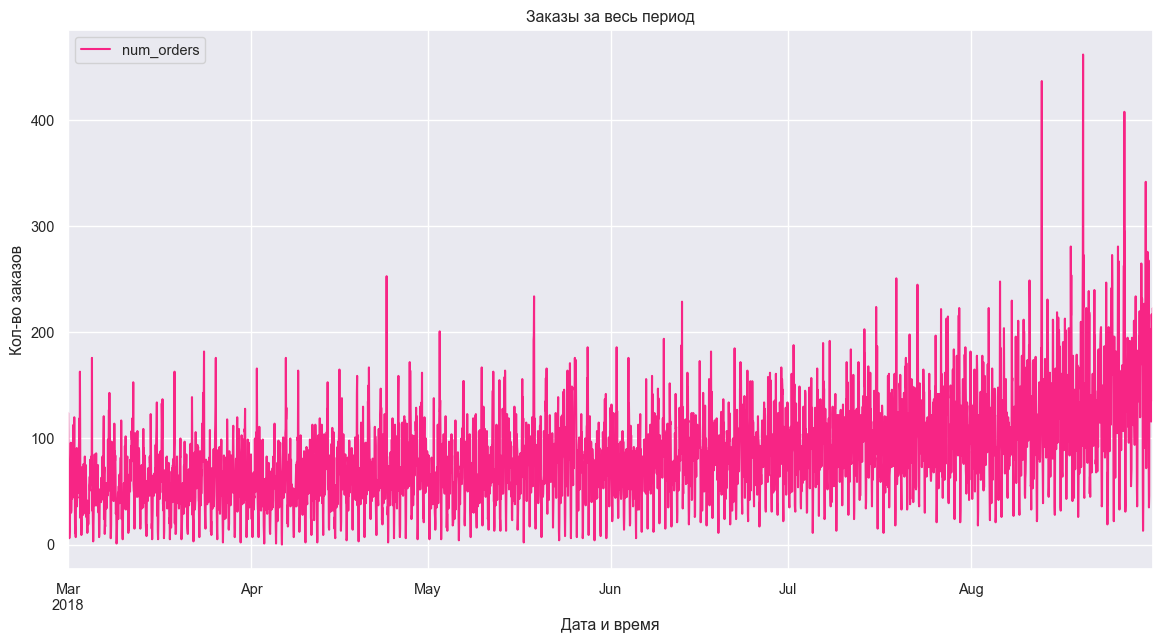

Среднее кол-во заказов с марта по июнь: 65.18
Среднее кол-во заказов с июня по август: 103.84


In [12]:
taxi.plot()
plt.title('Заказы за весь период')
plt.xlabel('Дата и время')
plt.ylabel('Кол-во заказов')
plt.show()

print(f'Среднее кол-во заказов с марта по июнь: \
{round(taxi[:"2018-06-01"]["num_orders"].mean(), 2)}')
print(f'Среднее кол-во заказов с июня по август: \
{round(taxi["2018-06-01":]["num_orders"].mean(), 2)}')

Проверим, является ли временный ряд нестационарным с помощью критерия Дики-Фуллера.

Нулевая гипотеза гласит: "Временной ряд является нестацинарным". Альтернативная: "Временной ряд стационарен".

In [13]:
p_value = adfuller(taxi['num_orders'])[1]
print('P =', p_value)
if p_value < 0.01:
    print('Нулевая гипотеза отвергается. Ряд стационарен по критерию Дики-Фуллера')
else:
    print('Нулевая гипотеза не отвергается. Ряд нестационарен по критерию Дики-Фуллера')

P = 0.028940051402613028
Нулевая гипотеза не отвергается. Ряд нестационарен по критерию Дики-Фуллера


p-значение больше уровня значимости (0.01). Нулевая гипотеза о нестационарности ряда не может быть опровергнута, но ее можно опровергнуть если `alpha`=0.05. Проанализируем скользящее среднее для более точного вывода.

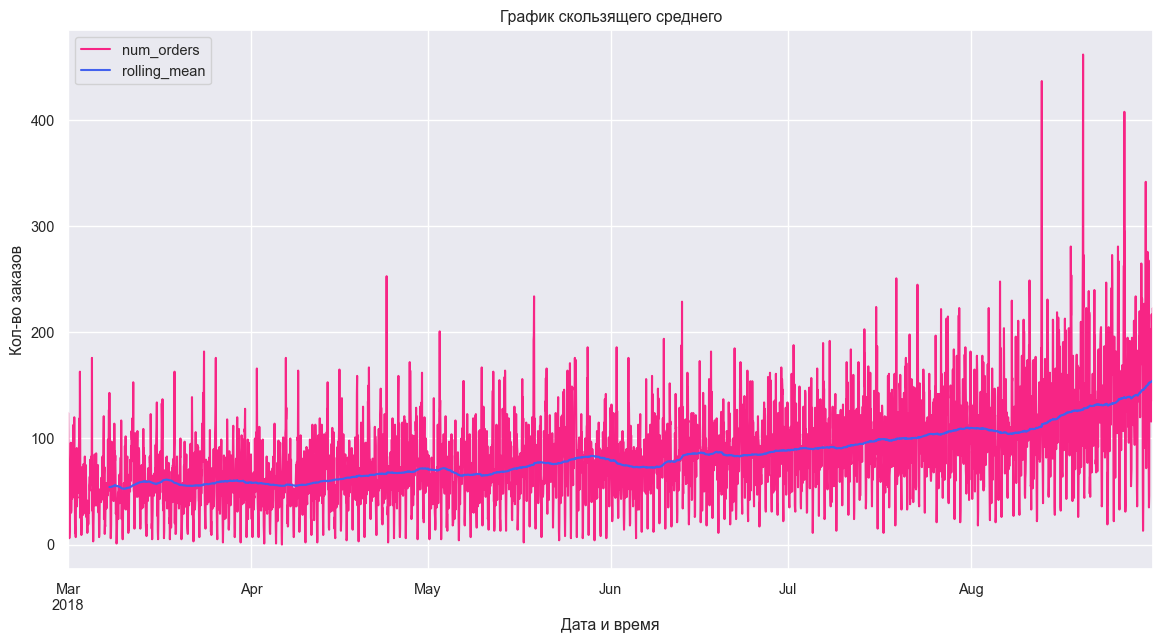

In [62]:
rolling_df = taxi.copy()
rolling_df['rolling_mean'] = rolling_df.shift()\
.rolling(window=24*7).mean()

rolling_df.plot()
plt.title('График скользящего среднего');
plt.xlabel('Дата и время')
plt.ylabel('Кол-во заказов')
plt.show();

По графику видно, что скользящее среднее увеличивается со временем, значит, ряд нестационарен.

Изучим тренды, сезонность и шумы.

In [15]:
decomposed = seasonal_decompose(taxi)

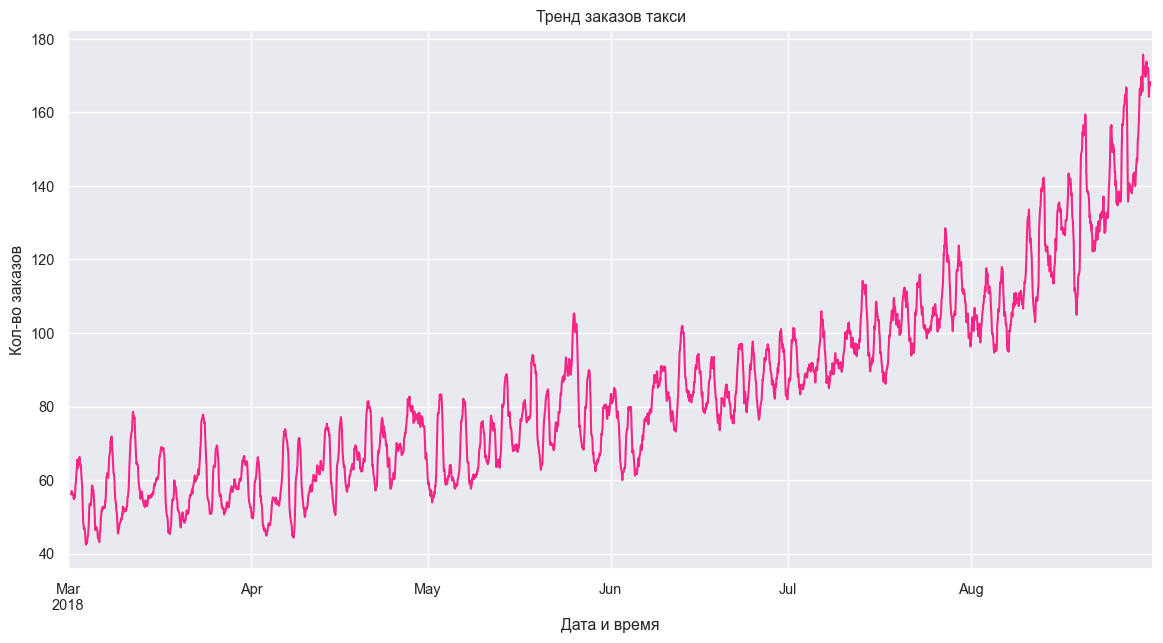

In [16]:
decomposed.trend.plot()
plt.xlabel('Дата и время')
plt.ylabel('Кол-во заказов')
plt.title('Тренд заказов такси');

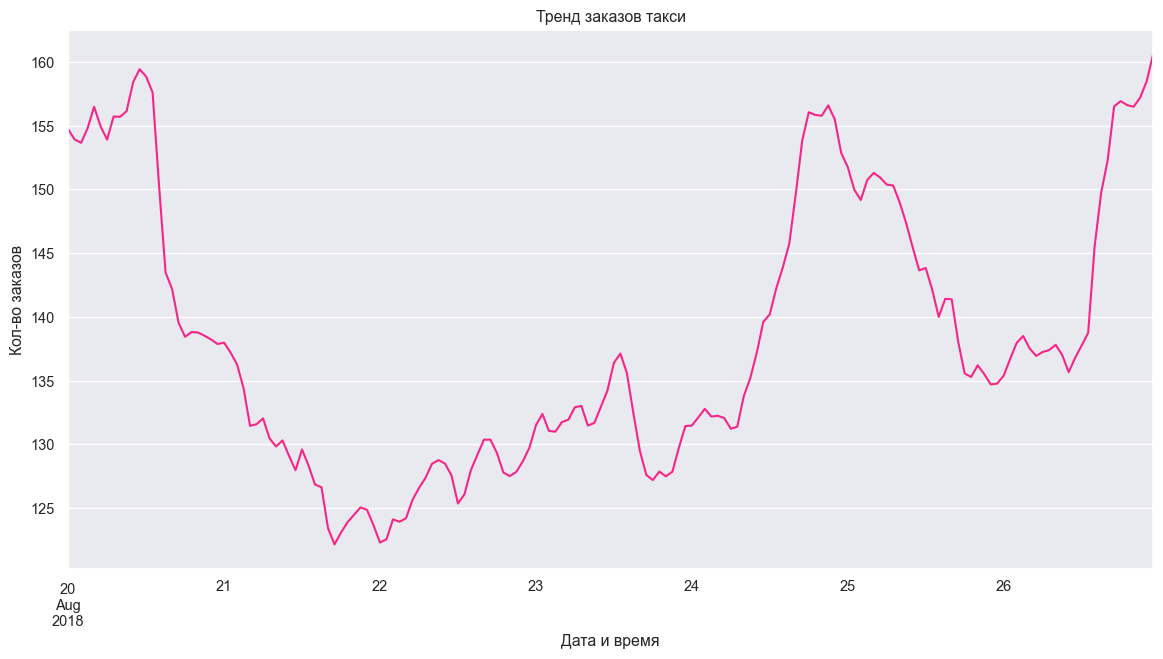

In [19]:
decomposed.trend['2018-08-20':'2018-08-26'].plot()
plt.xlabel('Дата и время')
plt.ylabel('Кол-во заказов')
plt.title('Тренд заказов такси');

Пик заказов ночью вс-утром пн, второй пик ночью пт-утром сб.

Cо временем количество заказов такси увеличивается.

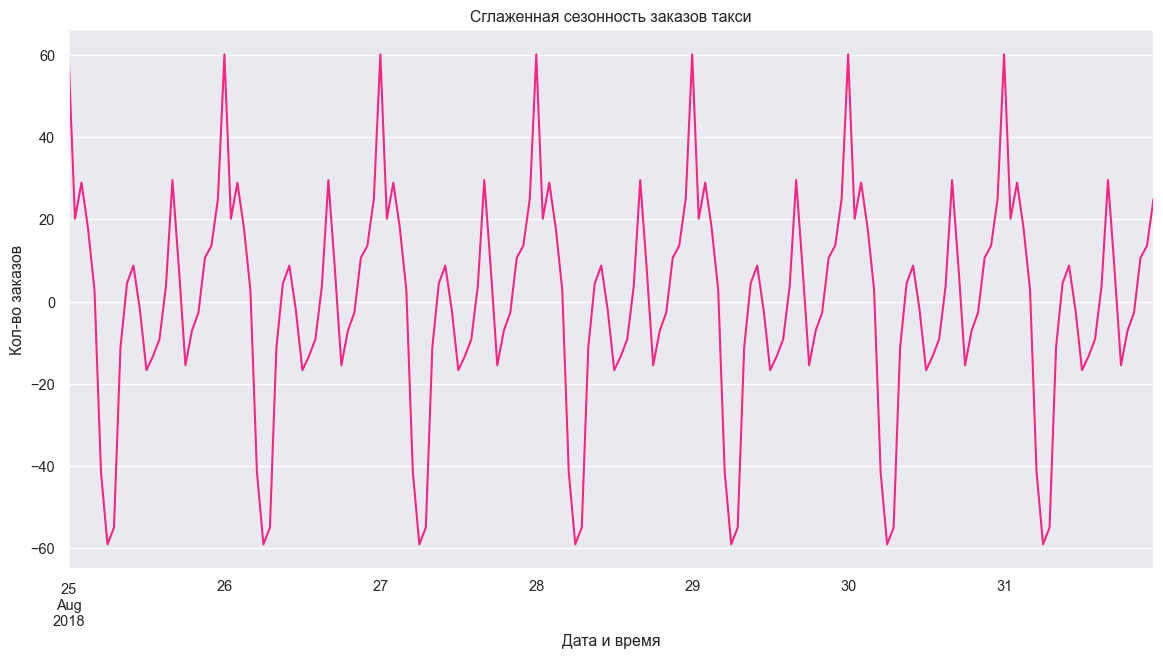

In [20]:
decomposed.seasonal.tail(24*7).plot()
plt.xlabel('Дата и время')
plt.ylabel('Кол-во заказов')
plt.title('Сглаженная сезонность заказов такси');

Посмотрим на сезонность состоит из колебаний в течение дня.

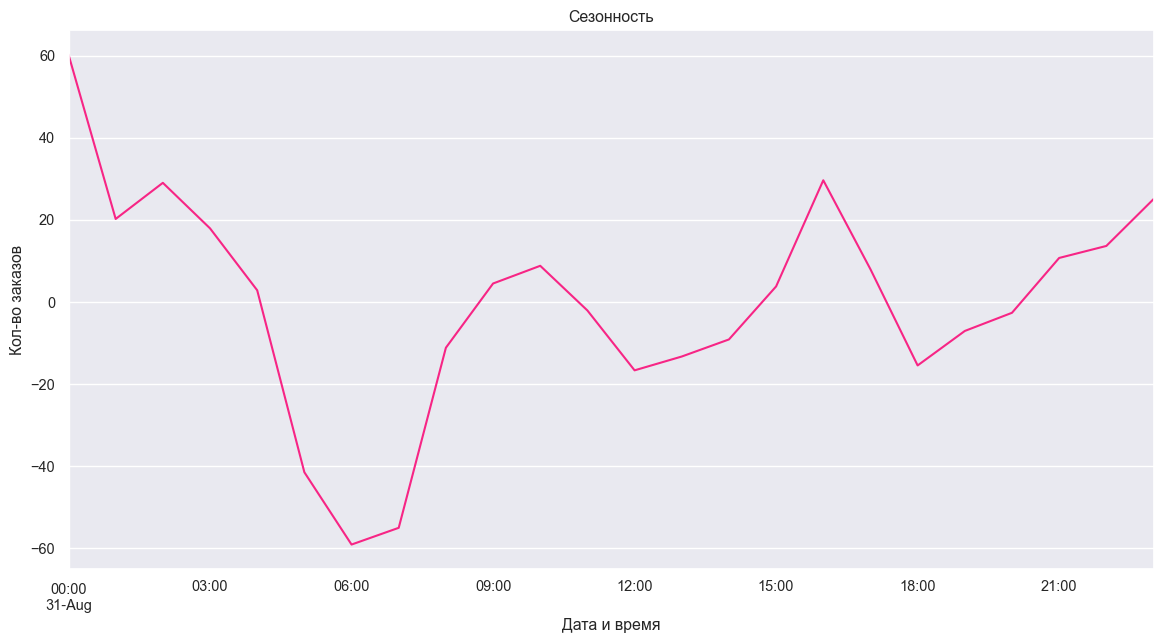

In [21]:
decomposed.seasonal['2018-08-31'].plot()
plt.xlabel('Дата и время')
plt.ylabel('Кол-во заказов')
plt.title('Сезонность');

- Минимальное количество заказов такси - в 6:00.
- Максимальное - 0:00.
- Также есть два пика в районе 10:00 и 16:00.

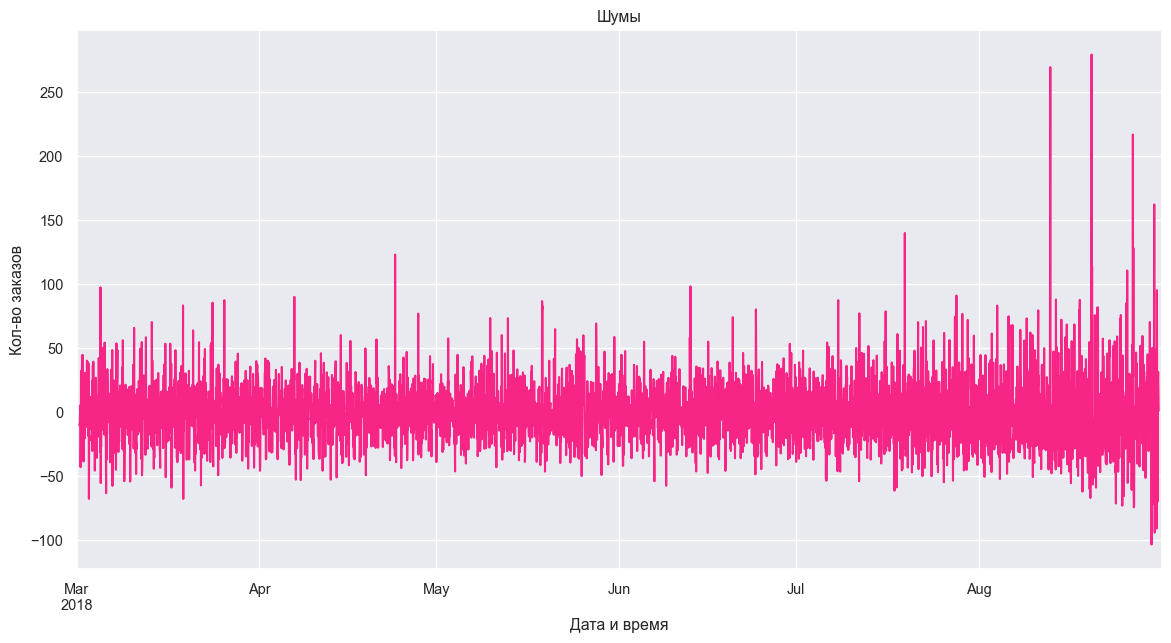

In [22]:
decomposed.resid.plot()
plt.xlabel('Дата и время')
plt.ylabel('Кол-во заказов')
plt.title('Шумы');

Во второй половине августа видны всплески шумов.

**Выводы:**
- наблюдается тренд - со временем количество заказов такси увеличивается;
- пик заказов ночью вс-утром пн, второй пик ночью пт-утром сб, менее всего заказов в середине недели;
- каждый день есть спрос на ночные и вечерние рейсы такси, к утру спрос падает;
    - минимальное количество заказов такси - в 6:00;
    - максимальное - 0:00;
    - также есть два пика в районе 10:00 и 16:00.
- данный ряд является нестационарным: скользящее среднее изменяется со временем и p-значение меньше уровня значимости, равного 0.01 (по тесту Дики-Фуллера).

Такие наблюдения можно объяснить тем, что люди чаще всего работают в середине недели (вт, ср, чт), поэтому данные дни недели не так удобны для полетов и поездок. Летние месяца пиковые, так как чаще всего отпуска берут на лето (курортное время, каникулы у детей и студентов). Время прибытия и отправления рейсов делится на четыре интервала: утро (06:00-12:00); день (12:00-18:00); вечер (18:00 до 00:00) и ночь (00:00 - 06:00), и у каждого из этих интервалов есть пиковое и минимальное по заказам такси время.

<a id='model'></a>
## Обучение моделей

<a id='prep'></a>
### Подготовка данных

Добавим новые признаки в датафрейм.
- `hour` - т.к. на графиках показаны пики и спады по часам.
- признак `day` - т.к. есть ежедневная сезонность.
- к концу недели и в понедельник спрос на такси увеличивается, следует добавить признак `dayofweek`.
- также добавим отстающее и скользящие среднее.

In [23]:
def new_features(df, max_lag, rolling_mean_size):
    new_df = df.copy()
    new_df['day'] = df.index.day
    new_df['dayofweek'] = df.index.dayofweek
    new_df['hour'] = df.index.hour
    
    for lag in range(1, max_lag + 1):
        col = 'lag_' + str(lag)
        new_df[col] = new_df['num_orders'].shift(lag)
    
    new_df['rolling_mean'] = new_df['num_orders']\
    .shift().rolling(rolling_mean_size).mean()
    return new_df.dropna()

In [24]:
data = new_features(taxi, 24, 24)
data.head()

,num_orders,day,dayofweek,hour,lag_1,lag_2,lag_3,lag_4,lag_5,lag_6,...,lag_16,lag_17,lag_18,lag_19,lag_20,lag_21,lag_22,lag_23,lag_24,rolling_mean
datetime,,,,,,,,,,,,,,,,,,,,,
2018-03-02 00:00:00,90,2,4,0,58.0,113.0,66.0,61.0,45.0,73.0,...,34.0,15.0,12.0,6.0,43.0,66.0,71.0,85.0,124.0,56.833333
2018-03-02 01:00:00,120,2,4,1,90.0,58.0,113.0,66.0,61.0,45.0,...,69.0,34.0,15.0,12.0,6.0,43.0,66.0,71.0,85.0,55.416667
2018-03-02 02:00:00,75,2,4,2,120.0,90.0,58.0,113.0,66.0,61.0,...,64.0,69.0,34.0,15.0,12.0,6.0,43.0,66.0,71.0,56.875000
2018-03-02 03:00:00,64,2,4,3,75.0,120.0,90.0,58.0,113.0,66.0,...,96.0,64.0,69.0,34.0,15.0,12.0,6.0,43.0,66.0,57.041667
2018-03-02 04:00:00,20,2,4,4,64.0,75.0,120.0,90.0,58.0,113.0,...,30.0,96.0,64.0,69.0,34.0,15.0,12.0,6.0,43.0,56.958333


In [25]:
# подготовим выборки для обучения моделей
X = data.drop('num_orders', axis=1)
y = data['num_orders']
X_train, X_test, y_train, y_test = train_test_split(
    X,
    y,
    shuffle=False,
    test_size=TEST_SIZE,
    random_state=RANDOM_STATE
    )

<a id='lin'></a>
### Линейная модель

Сначала обработаем данные: выполняем масштабирование и кодирование.

In [26]:
ohe_columns = ['day', 'dayofweek', 'hour']
num_columns = X_train.drop(
    ['day', 
     'dayofweek', 
     'hour'], axis=1).columns.to_list()

In [27]:
# SimpleImputer + OHE
ohe_pipe = Pipeline(
   [('simpleImputer_ohe', 
     SimpleImputer(missing_values=np.nan, strategy='most_frequent')),
    ('ohe', OneHotEncoder(drop='first', handle_unknown='ignore', sparse_output=False))
   ]
   )

In [28]:
data_preprocessor = ColumnTransformer(
    [
        ('ohe', ohe_pipe, ohe_columns),
        ('num', StandardScaler(), num_columns)
    ],
    remainder='passthrough'
)

In [29]:
pipe_final = Pipeline([
    ('preprocessor', data_preprocessor),
    ('models', LinearRegression()
    )
])

In [30]:
tscv = TimeSeriesSplit(n_splits=3)

param_grid = [
    # словарь для модели LinearRegression()
    {
        'models': [LinearRegression()],  
        'preprocessor__num': [StandardScaler(), 
                              MinMaxScaler(), 
                              'passthrough']  
    }
]

gs_lr = GridSearchCV(
    pipe_final,
    param_grid,
    cv = tscv,
    scoring = 'neg_root_mean_squared_error',
    n_jobs = -1
)

In [31]:
gs_lr.fit(X_train, y_train)

print('Модель и лучшие параметры:\n\n', gs_lr.best_estimator_)
print ('RMSE:', gs_lr.best_score_ * -1)

Модель и лучшие параметры:

 Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('ohe',
                                                  Pipeline(steps=[('simpleImputer_ohe',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('ohe',
                                                                   OneHotEncoder(drop='first',
                                                                                 handle_unknown='ignore',
                                                                                 sparse_output=False))]),
                                                  ['day', 'dayofweek', 'hour']),
                                                 ('num', 'passthrough',
                                                  ['lag_1', 'lag_2', 'lag_3',
            

<a id='lgbm'></a>
### Модель LightGBM

In [32]:
model_lgbm = LGBMRegressor(objective='root_mean_squared_error',
                           random_state=RANDOM_STATE,
                           verbose=-1)

param_grid_lgbm = {
    'num_leaves': [50, 100, 200],
    'max_depth': [10, 50, 100]
}

gs_lgbm = GridSearchCV(
    model_lgbm,
    param_grid_lgbm,
    cv = tscv,
    scoring = 'neg_root_mean_squared_error',
    n_jobs = -1
)

In [33]:
gs_lgbm.fit(X_train, y_train)

print('Модель и лучшие параметры:\n\n', gs_lgbm.best_estimator_)
print ('RMSE:', gs_lgbm.best_score_ * -1)

Модель и лучшие параметры:

 LGBMRegressor(max_depth=10, num_leaves=100, objective='root_mean_squared_error',
              random_state=52, verbose=-1)
RMSE: 26.589408630966172


<a id='tree'></a>
### Модель DecisionTreeRegressor

In [34]:
param_grid_tree = [
   # словарь для модели DecisionTreeRegressor()
   {
       'models': [DecisionTreeRegressor(random_state=RANDOM_STATE)],
      # 'models__min_samples_split': range(2, 100),
      # 'models__min_samples_leaf': range(2, 50),
       'models__max_depth': range(2, 10),
       'preprocessor__num': [StandardScaler(), MinMaxScaler(), 'passthrough'] 
   },
]

gs_tree = GridSearchCV(
    pipe_final,
    param_grid_tree,
    cv = tscv,
    scoring = 'neg_root_mean_squared_error',
    n_jobs = -1
)

In [35]:
gs_tree.fit(X_train, y_train)

print('Модель и лучшие параметры:\n\n', gs_tree.best_estimator_)
print ('RMSE:', gs_tree.best_score_ * -1)

Модель и лучшие параметры:

 Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('ohe',
                                                  Pipeline(steps=[('simpleImputer_ohe',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('ohe',
                                                                   OneHotEncoder(drop='first',
                                                                                 handle_unknown='ignore',
                                                                                 sparse_output=False))]),
                                                  ['day', 'dayofweek', 'hour']),
                                                 ('num', StandardScaler(),
                                                  ['lag_1', 'lag_2', 'lag_3',
         

<a id='comp'></a>
### Сравнение моделей

In [36]:
models_df = pd.DataFrame(
    {'model':['LinearRegression', 
              'LightGBM', 
              'DecisionTree'],
     'RMSE': [abs(gs_lr.best_score_), 
              abs(gs_lgbm.best_score_),
              abs(gs_tree.best_score_)],
    }
)
models_df

,model,RMSE
0,LinearRegression,27.891710
1,LightGBM,26.589409
2,DecisionTree,32.000984


**Вывод:** судя по метрике RMSE при кросс-валидации, лучшая модель - **LightGBM** с параметрами `max_depth=50`, `num_leaves=50`. Ее RMSE равна 27.32.

<a id='test'></a>
### Качество лучшей модели на тестовой выборке

In [37]:
best_model = gs_lgbm.best_estimator_

RMSE_test = mean_squared_error(
    y_test,
    best_model.predict(X_test), 
    squared = False)

print('RMSE на тестовой выборке: ', round(RMSE_test, 2))

RMSE на тестовой выборке:  42.14


Метрика **RMSE** равная `40.66` соответсвует критериям (*Значение метрики RMSE на тестовой выборке должно быть не больше 48*).

Построим график для наглядности.

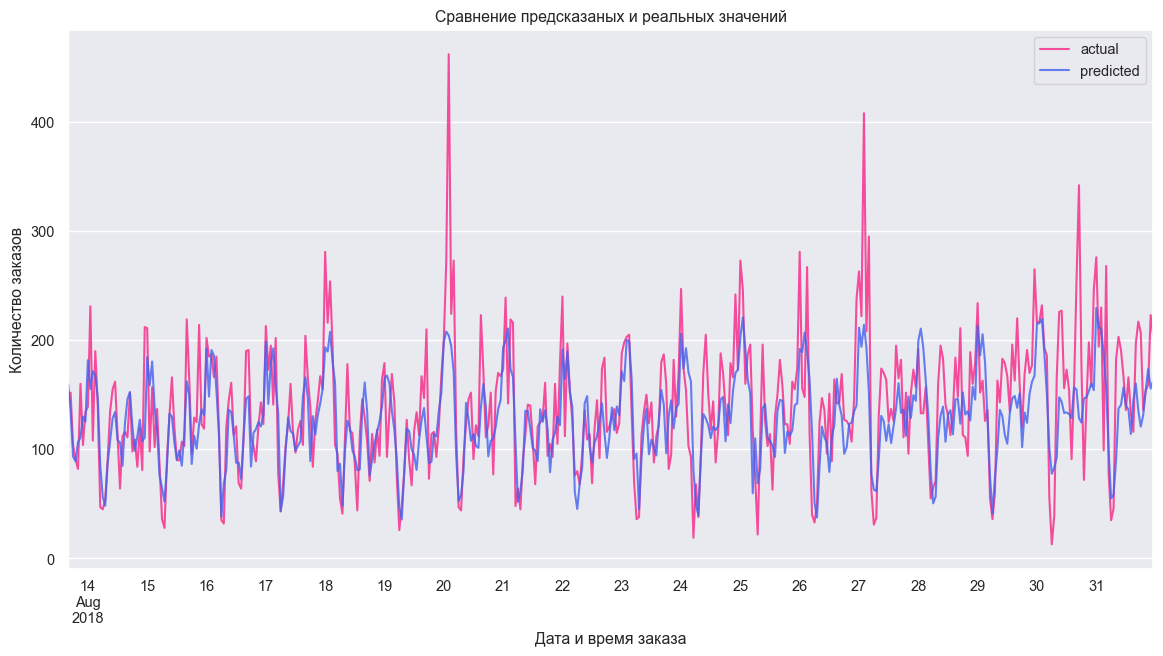

In [38]:
pred = best_model.predict(X_test)

y_pred = pd.DataFrame(pred, columns=['predicted'])
y_true = pd.DataFrame(y_test.values, columns=['actual'])

compare = pd.concat([y_true, y_pred], axis=1)
compare.index = y_test.index
compare.plot(alpha=0.8)
plt.title('Сравнение предсказаных и реальных значений')
plt.xlabel('Дата и время заказа')
plt.ylabel('Количество заказов');

Выбранная модель хорошо справляется с минимальными значениями, но хуже предсказывает неожиданно высокие пики.

Оценим модель, сравнив качество ее предсказаний с качеством модели, предсказывающей константу.

In [40]:
dc_check = DummyRegressor(strategy='constant', constant=0) 
dc_check.fit(X_train, y_train) 

dc_pred = dc_check.predict(X_test) 
dc_rmse = mean_squared_error(
    y_test,
    dc_pred, 
    squared = False)
print ('RMSE:', dc_rmse)

RMSE: 151.37685514214937


Значение метрики на нашей модели намного лучше, чем на константной модели.

In [41]:
# функция предсказывания значений
# на следующий период
def forecast(model, old_data, n_periods):
    predictions = []
    current_data = old_data.copy()

    for ш in range(n_periods):
        # cоздаем новые признаки
        features = new_features(current_data, 24, 24)\
        .iloc[-1:].drop('num_orders', axis=1)
        
        # прогнозируем одно значение
        prediction = model.predict(features)[0]
        predictions.append(prediction)
        
        # добавление прогноза как новое наблюдение в данные
        new_row = current_data.iloc[-1:].copy()
        new_row['num_orders'] = prediction
        current_data = pd.concat([current_data, new_row])
    
    return predictions

In [42]:
n_periods = 1

# Выполняем итеративный прогноз
forecasts = forecast(best_model, taxi, n_periods)
print(f'Прогноз для кол-ва периодов, равных {n_periods}: {forecasts}')

Прогноз для кол-ва периодов, равных 1: [162.80070822916755]


<a id='fin'></a>
## Общие выводы

**Цели проекта выполнены:** 
- Загружен датафрейм и выполнено ресемплирование данных.
- Исследованы данные.
- Подготовлены выборки для обучения моделей.
- Обучены разные модели и подобраны гиперпараметры.
- Проанализировано качество моделей и выбрана лучшая, предсказывающая количество заказов такси в следующий период (1 час), проверено её качество на тестовой выборке.

**Исходные данные:**
- Данные о заказах такси, находящиеся в файле `taxi.csv`.
- **Целевой признак:** `num_orders` — кол-во заказов.

**В ходе выполнения работы проделаны следующие шаги:**
- Загружены и проверены соответствия данных в датафреймах;
- Выполнено ресемплирование данных по одному часу;
- В ходе **исследовательского анализа данных** получены следующие данные:
    - Наблюдается тренд - со временем количество заказов такси увеличивается;
    - Пик заказов ночью вс-утром пн, второй пик ночью пт-утром сб, менее всего заказов в середине недели;
    - Каждый день есть спрос на ночные и вечерние рейсы такси, к утру спрос падает;
        - минимальное количество заказов такси - в 6:00;
        - максимальное - 0:00;
        - также есть два пика в районе 10:00 и 16:00.
            - Такие наблюдения можно объяснить тем, что люди чаще всего работают в середине недели (вт, ср, чт), поэтому данные дни недели не так удобны для полетов и поездок. Летние месяца пиковые, так как чаще всего отпуска берут на лето (курортное время, каникулы у детей и студентов). Время прибытия и отправления рейсов делится на четыре интервала: утро (06:00-12:00); день (12:00-18:00); вечер (18:00 до 00:00) и ночь (00:00 - 06:00), и у каждого из этих интервалов есть пиковое и минимальное по заказам такси время.

    - данный ряд является нестационарным: скользящее среднее изменяется со временем и p-значение меньше уровня значимости, равного 0.01 (по тесту Дики-Фуллера)

--------------------------------------------------------------------------
- Обучены модели (`LinearRegression`, `LightGBM`, `DecisionTree`): 
     - Добавлены новые признаки: календарные, отстающие значения и скользящее среднее.
     - Лучшей моделью является **LightGBM** с параметрами `max_depth=50`, `num_leaves=50`. Метрика модели соответсвует критериям заказчика (*значение на тестовой выборке  не больше 48*) и дает следующие результаты:
        - Метрика **RMSE** на тренировочной выборке: 27.32
        - Метрика **RMSE** на тестовой выбборке: 40.66
        
Выбранная модель хорошо справляется с минимальными значениями, но хуже предсказывает неожиданно высокие пики.

[Наверх][1]

[1]:#task